In [ ]:
!pip list | grep torch

torch                                    2.8.0+cu126
torchao                                  0.10.0
torchaudio                               2.8.0+cu126
torchdata                                0.11.0
torchsummary                             1.5.1
torchtune                                0.6.1
torchvision                              0.23.0+cu126


In [ ]:
import torch

*   https://pytorch.org/blog/quantization-in-practice/
*   https://pytorch.org/docs/stable/quantization.html
*   https://pytorch.org/docs/stable/quantization-support.html

### Mapping function and Quantization Parameters

In [ ]:
# r - float tensor, r' - int tensor
# S [scaling factor] = (beta - alpha) / (beta_q - alpha_q)
# Z [zero point] =  -(alpha / S - alpha_q)

def quantize(float_tensor, scale, z):
  # Q(r) = round(r/S + Z)
  return torch.round(float_tensor / scale + z)

def dequantize(int_tensor, scale, z):
  # r' = (Q(r) - Z) * S
  return (int_tensor - z) * scale

In [ ]:
from torch.ao.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver

C, L = 3, 4
normal = torch.distributions.normal.Normal(0,1)
inputs = normal.sample((C, L))
print(inputs)

tensor([[ 0.3662,  0.1390,  0.3182,  0.4773],
        [ 0.1317,  0.3808, -0.4732, -1.9495],
        [ 1.0165,  0.3677,  0.2789,  1.4896]])


In [ ]:
observers = [MinMaxObserver(), MovingAverageMinMaxObserver(), HistogramObserver()]
for obs in observers:
  obs(inputs)
  print(obs.__class__.__name__, obs.calculate_qparams())

MinMaxObserver (tensor([0.0135]), tensor([145], dtype=torch.int32))
MovingAverageMinMaxObserver (tensor([0.0135]), tensor([145], dtype=torch.int32))
HistogramObserver (tensor([0.0135]), tensor([145], dtype=torch.int32))


In [ ]:
scale, z = observers[0].calculate_qparams()
reconstruction_error = torch.abs(dequantize(quantize(inputs, scale, z), scale, z) - inputs)
reconstruction_error

tensor([[0.0021, 0.0042, 0.0055, 0.0052],
        [0.0032, 0.0032, 0.0012, 0.0060],
        [0.0050, 0.0036, 0.0043, 0.0060]])

### Affine and Symmetric Quantization Schemes

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def get_symmetric_range(x):
  beta = torch.max(x.max(), x.min().abs())
  return -beta.item(), beta.item()

def get_affine_range(x):
  return x.min().item(), x.max().item()

def plot(plt, data, scheme):
  boundaries = get_affine_range(data) if scheme == 'affine' else get_symmetric_range(data)
  a, _, _ = plt.hist(data, density=True, bins=100)
  ymin, ymax = np.quantile(a[a>0], [0.25, 0.95])
  plt.vlines(x=boundaries, ls='--', colors='purple', ymin=ymin, ymax=ymax)

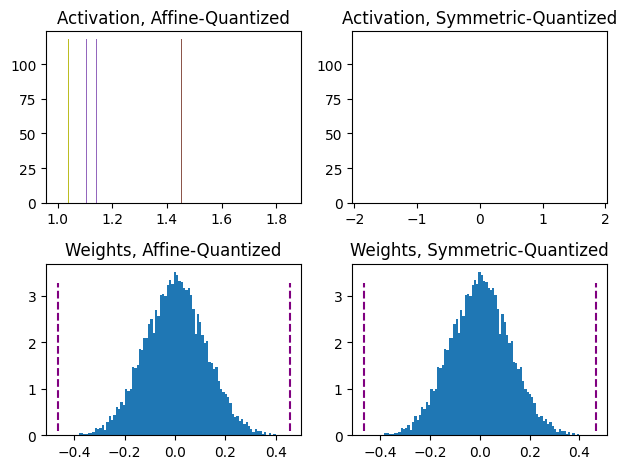

In [ ]:
act =  torch.distributions.pareto.Pareto(1, 10).sample((1, 1024))
weights = torch.distributions.normal.Normal(0, 0.12).sample((3, 64, 7, 7)).flatten()

fig, axs = plt.subplots(2,2)
plot(axs[0, 0], act, 'affine')
axs[0, 0].set_title("Activation, Affine-Quantized")

plot(axs[0, 1], act, 'symmetric')
axs[0, 1].set_title("Activation, Symmetric-Quantized")

plot(axs[1, 0], weights, 'affine')
axs[1, 0].set_title("Weights, Affine-Quantized")

plot(axs[1, 1], weights, 'symmetric')
axs[1, 1].set_title("Weights, Symmetric-Quantized")

fig.tight_layout()
plt.show()

In [ ]:
for qscheme in [torch.per_tensor_affine, torch.per_tensor_symmetric]:
  obs = MovingAverageMinMaxObserver(qscheme=qscheme)
  obs(inputs)
  print(f"Qscheme: {qscheme} | {obs.calculate_qparams()}")

Qscheme: torch.per_tensor_affine | (tensor([0.0135]), tensor([145], dtype=torch.int32))
Qscheme: torch.per_tensor_symmetric | (tensor([0.0153]), tensor([128]))


### Per-Tensor and Per-Channel Quantization Schemes

In [ ]:
from torch.ao.quantization.observer import MovingAveragePerChannelMinMaxObserver

obs = MovingAveragePerChannelMinMaxObserver(ch_axis = 0)  # calculate qparams for all `C` channels separately
obs(inputs)
print(obs.calculate_qparams())

(tensor([0.0019, 0.0091, 0.0058]), tensor([  0, 213,   0], dtype=torch.int32))


For weights quantization, symmetric-per-channel quantization provides better accuracies; per-tensor quantization performs poorly, possibly due to high variance in conv weights across channels from batchnorm folding.
[https://arxiv.org/abs/2004.09602]

https://github.com/pytorch/pytorch/blob/748d9d24940cd17938df963456c90fa1a13f3932/torch/ao/quantization/observer.py#L258

### Backend Engine

In [ ]:
backend = 'fbgemm' #'fbgemm' if x86 else 'qnnpack' intel - oneDNN
qconfig = torch.ao.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend

GPUs - via TensorRT and cuDNN
https://pytorch.org/docs/stable/quantization.html#note-for-native-cpu-backends

### QConfig

In [ ]:
my_qconfig = torch.ao.quantization.QConfig(
  activation=MovingAverageMinMaxObserver.with_args(qscheme=torch.per_tensor_affine),
  weight=MovingAveragePerChannelMinMaxObserver.with_args(qscheme=torch.qint8))

my_qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.MovingAverageMinMaxObserver'>, qscheme=torch.per_tensor_affine){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MovingAveragePerChannelMinMaxObserver'>, qscheme=torch.qint8){})

torch.per_channel_affine

### Eager Mode v/s FX Graph Mode

*    Eager Mode Quantization is a beta feature. User needs to do fusion and specify where quantization and dequantization happens manually, also it only supports modules and not functionals.
*    FX Graph Mode Quantization is a new automated quantization framework in PyTorch, and currently it’s a prototype feature. It improves upon Eager Mode Quantization by adding support for functionals and automating the quantization process, although people might need to refactor the model to make the model compatible with FX Graph Mode Quantization (symbolically traceable with torch.fx)






FX Graph Mode automatically fuses eligible modules, inserts Quant/DeQuant stubs, calibrates the model and returns a quantized module - all in two method calls - but only for networks that are symbolic traceable. The examples below contain the calls using Eager Mode and FX Graph Mode for comparison.
https://pytorch.org/docs/stable/fx.html#torch.fx.symbolic_trace

In [ ]:
def f(a, b):
    if b == True:
        return a
    else:
        return a * 2

In [ ]:
f = torch.fx.symbolic_trace(f, concrete_args={'b': False})
assert f(3, True) == 6

AssertionError: b has been specialized to have value False but got another value

https://pytorch.org/docs/stable/fx.html

### Post-Training Dynamic/Weight-only Quantization

Here the model’s weights are pre-quantized; the activations are quantized on-the-fly (“dynamic”) during inference. The simplest of all approaches, it has a one line API call in torch.quantization.quantize_dynamic. Currently only Linear and Recurrent (LSTM, GRU, RNN) layers are supported for dynamic quantization



*   Can result in higher accuracies since the clipping range is exactly calibrated for each input
*   Calibrating and quantizing the activations at each layer during runtime can add to the compute overhead



In [ ]:
from torch import nn

# toy model
m = nn.Sequential(
  nn.Conv2d(2, 64, (8,)),
  nn.ReLU(),
  nn.Linear(16, 10),
  nn.LSTM(10, 10))

m.eval()

Sequential(
  (0): Conv2d(2, 64, kernel_size=(8,), stride=(1, 1))
  (1): ReLU()
  (2): Linear(in_features=16, out_features=10, bias=True)
  (3): LSTM(10, 10)
)

In [ ]:
## EAGER MODE
from torch.ao.quantization import quantize_dynamic

model_quantized = quantize_dynamic(
    model=m, qconfig_spec={nn.LSTM, nn.Linear}, dtype=torch.qint8, inplace=False
)

/tmp/ipython-input-2181302342.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_dynamic(


In [ ]:
## FX MODE
from torch.ao.quantization import quantize_fx

example_inputs = (torch.randn(1, 3, 224, 224),)
qconfig_dict = {"": torch.ao.quantization.default_dynamic_qconfig}  # An empty key denotes the default applied to all modules
model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, example_inputs)
model_quantized = quantize_fx.convert_fx(model_prepared)

/tmp/ipython-input-15622409.py:6: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConf

In [ ]:
torch.ao.quantization.default_dynamic_qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.PlaceholderObserver'>, dtype=torch.quint8, quant_min=0, quant_max=255, is_dynamic=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric){})

### Post-Training Static Quantization (PTQ)

PTQ also pre-quantizes model weights but instead of calibrating activations on-the-fly, the clipping range is pre-calibrated and fixed (“static”) using validation data. Activations stay in quantized precision between operations during inference. About 100 mini-batches of representative data are sufficient to calibrate the observers

*   Static quantization has faster inference than dynamic quantization because it eliminates the float<->int conversion costs between layers
*   Static quantized models may need regular re-calibration to stay robust against distribution-drift



In [ ]:
# Static quantization of a model consists of the following steps:

#     Fuse modules
#     Insert Quant/DeQuant Stubs
#     Prepare the fused module (insert observers before and after layers)
#     Calibrate the prepared module (pass it representative data)
#     Convert the calibrated module (replace with quantized version)

import torch
from torch import nn
import copy

backend = "fbgemm"  # running on a x86 CPU. Use "qnnpack" if running on ARM.

model = nn.Sequential(
     nn.Conv2d(2, 64, 3),
     nn.ReLU(),
     nn.Conv2d(64, 128, 3),
     nn.ReLU()
)

TypeError: 'Parameter' object is not callable

In [ ]:
## EAGER MODE
m = copy.deepcopy(model)
m.eval()

"""Fuse
- Inplace fusion replaces the first module in the sequence with the fused module, and the rest with identity modules
"""
torch.ao.quantization.fuse_modules(m, ['0','1'], inplace=True) # fuse first Conv-ReLU pair
torch.ao.quantization.fuse_modules(m, ['2','3'], inplace=True) # fuse second Conv-ReLU pair

"""Insert stubs"""
m = nn.Sequential(torch.ao.quantization.QuantStub(),
                  *m,
                  torch.ao.quantization.DeQuantStub())

"""Prepare"""
m.qconfig = torch.ao.quantization.get_default_qconfig(backend)
torch.ao.quantization.prepare(m, inplace=True)

"""Calibrate
- This example uses random data for convenience. Use representative (validation) data instead.
"""
with torch.inference_mode():
  for _ in range(10):
    x = torch.rand(1, 2, 28, 28)
    m(x)

"""Convert"""
torch.ao.quantization.convert(m, inplace=True)

"""Check"""
print(m[1].weight().element_size()) # 1 byte instead of 4 bytes for FP32

1


/tmp/ipython-input-213743822.py:18: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.ao.quantization.prepare(m, inplace=True)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorc

In [ ]:
m[1].weight()

tensor([[[[ 0.2192, -0.1191,  0.0293],
          [-0.0138, -0.1536,  0.1191],
          [ 0.0811,  0.0604,  0.2175]],

         [[ 0.0069, -0.0863, -0.0794],
          [-0.1554, -0.0794,  0.1433],
          [ 0.0190,  0.1364,  0.1554]]],


        [[[ 0.0805, -0.1216,  0.1162],
          [-0.0662, -0.0143,  0.0680],
          [ 0.1216,  0.2146,  0.1413]],

         [[-0.2289,  0.1967, -0.0733],
          [-0.0107,  0.1592, -0.0143],
          [-0.0036,  0.0912,  0.1449]]],


        [[[-0.0942, -0.1309,  0.1692],
          [ 0.0995,  0.1012, -0.1099],
          [-0.0262,  0.0192,  0.0087]],

         [[ 0.1064,  0.0017,  0.1256],
          [-0.2094,  0.1064, -0.0628],
          [ 0.2216,  0.1815,  0.2216]]],


        ...,


        [[[-0.0036,  0.0874,  0.0473],
          [ 0.0874,  0.0983, -0.2203],
          [ 0.2313,  0.1074,  0.1475]],

         [[-0.0437,  0.0874, -0.2276],
          [ 0.1584, -0.1348, -0.1912],
          [ 0.1584, -0.0091,  0.1967]]],


        [[[ 0.0632,  0.20

In [ ]:
## FX GRAPH
from torch.ao.quantization import quantize_fx

m = copy.deepcopy(model)
m.eval()
qconfig_dict = {"": torch.ao.quantization.get_default_qconfig(backend)}

# Prepare
example_inputs = (torch.randn(1, 3, 224, 224),)
model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, example_inputs)

# Calibrate - Use representative (validation) data.
with torch.inference_mode():
  for _ in range(10):
    x = torch.rand(1, 2, 28, 28)
    model_prepared(x)

# quantize
model_quantized = quantize_fx.convert_fx(model_prepared)

/tmp/ipython-input-750729956.py:10: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, example_inputs)
/tmp/ipython-input-750729956.py:19: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.q

### SENSITIVITY ANALYSIS

In [ ]:
# ONE-AT-A-TIME SENSITIVITY ANALYSIS

for quantized_layer, _ in model.named_modules():
  print("Only quantizing layer: ", quantized_layer)

  # The module_name key allows module-specific qconfigs.
  qconfig_dict = {"": None,
  "module_name":[(quantized_layer, torch.quantization.get_default_qconfig(backend))]}

  example_inputs = (torch.randn(1, 3, 224, 224),)
  model_prepared = quantize_fx.prepare_fx(model, qconfig_dict, example_inputs)
  # calibrate
  model_quantized = quantize_fx.convert_fx(model_prepared)
  # evaluate(model)

Only quantizing layer:  
Only quantizing layer:  0
Only quantizing layer:  1
Only quantizing layer:  2
Only quantizing layer:  3


/tmp/ipython-input-1147990886.py:11: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = quantize_fx.prepare_fx(model, qconfig_dict, example_inputs)
/tmp/ipython-input-1147990886.py:13: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torc

 Numeric Suite - https://pytorch.org/tutorials/prototype/numeric_suite_tutorial.html

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import os
import torch.ao.quantization
import torch.ao.ns._numeric_suite as ns
from torch.ao.quantization import (
    default_eval_fn,
    default_qconfig,
    quantize,
)

In [ ]:
float_model = torchvision.models.quantization.resnet18(pretrained=True, quantize=False)
float_model.to('cpu')
float_model.eval()
float_model.fuse_model()
float_model.qconfig = torch.quantization.default_qconfig
img_data = (torch.rand(2, 3, 10, 10, dtype=torch.float), torch.randint(0, 1, (2,), dtype=torch.long))
qmodel = quantize(float_model, default_eval_fn, [[img_data]], inplace=False)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]
/tmp/ipython-input-409614095.py:7: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  qmodel = quantize(float_model, default_eval_fn, [[img_data]], inplace=False)


In [ ]:
def compute_error(x, y):
    Ps = torch.norm(x)
    Pn = torch.norm(x - y)
    return 20 * torch.log10(Ps/Pn)

wt_compare_dict = ns.compare_weights(float_model.state_dict(), qmodel.state_dict())
for key in wt_compare_dict:
    print(key, compute_error(wt_compare_dict[key]['float'], wt_compare_dict[key]['quantized'].dequantize()))

print("---")

act_compare_dict = ns.compare_model_outputs(float_model, qmodel, img_data[0])
for key in act_compare_dict:
    print(key, compute_error(act_compare_dict[key]['float'][0], act_compare_dict[key]['quantized'][0].dequantize()))


conv1.weight tensor(31.6638)
layer1.0.conv1.weight tensor(30.6450)
layer1.0.conv2.weight tensor(31.1528)
layer1.1.conv1.weight tensor(32.1438)
layer1.1.conv2.weight tensor(31.2477)
layer2.0.conv1.weight tensor(30.9890)
layer2.0.conv2.weight tensor(28.8233)
layer2.0.downsample.0.weight tensor(31.5558)
layer2.1.conv1.weight tensor(30.7668)
layer2.1.conv2.weight tensor(28.4516)
layer3.0.conv1.weight tensor(30.9247)
layer3.0.conv2.weight tensor(26.6841)
layer3.0.downsample.0.weight tensor(28.7825)
layer3.1.conv1.weight tensor(28.9707)
layer3.1.conv2.weight tensor(25.6784)
layer4.0.conv1.weight tensor(26.8495)
layer4.0.conv2.weight tensor(25.8394)
layer4.0.downsample.0.weight tensor(28.6355)
layer4.1.conv1.weight tensor(26.8758)
layer4.1.conv2.weight tensor(28.4319)
fc._packed_params._packed_params tensor(32.6505)
---
conv1.stats tensor(37.5421, grad_fn=<MulBackward0>)
layer1.0.conv1.stats tensor(29.6261, grad_fn=<MulBackward0>)
layer1.0.conv2.stats tensor(28.6099, grad_fn=<MulBackward0>)
l

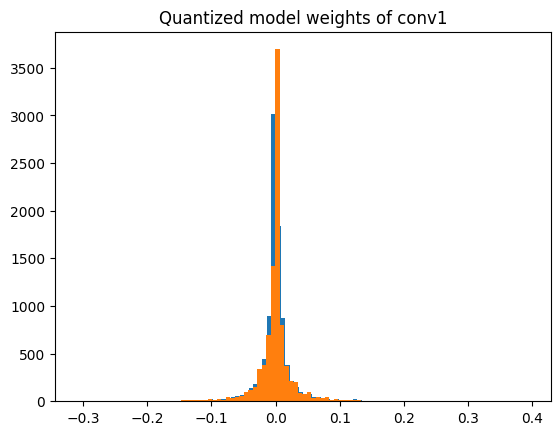

In [ ]:
import matplotlib.pyplot as plt

f = wt_compare_dict['conv1.weight']['float'].flatten()
plt.hist(f, bins = 100)

q = wt_compare_dict['conv1.weight']['quantized'].flatten().dequantize()
plt.hist(q, bins = 100)
plt.title("Quantized model weights of conv1")
plt.show()

### RECOMMENDATIONS FOR YOUR WORKFLOW

![](https://drive.google.com/uc?export=view&id=1ij7GElwiKFNmJ221aKpkDRwMj5i-2DLh)



*   Large (10M+ parameters) models are more robust to quantization error
*   Quantizing a model from a FP32 checkpoint provides better accuracy than training an INT8 model from scratch
*   Dynamic Quantization is an easy first step, especially if your model has many Linear or Recurrent layers
*   Use symmetric-per-channel quantization with MinMax observers for quantizing weights. Use affine-per-tensor quantization with MovingAverageMinMax observers for quantizing activations
*   Use metrics like SQNR to identify which layers are most suscpetible to quantization error. Turn off quantization on these layers

Eager mode https://pytorch.org/docs/stable/quantization.html#eager-mode-quantization



*   https://pytorch.org/docs/stable/quantization.html#post-training-dynamic-quantization
*   https://pytorch.org/docs/stable/quantization.html#post-training-static-quantization


FX Graph https://pytorch.org/docs/stable/quantization.html#prototype-fx-graph-mode-quantization



*   https://pytorch.org/tutorials/prototype/fx_graph_mode_ptq_static.html
*   https://pytorch.org/tutorials/prototype/fx_graph_mode_ptq_dynamic.html





## New forkflow with torchao



In [ ]:
!pip install torchao

In [ ]:
import copy
import torch

class ToyLinearModel(torch.nn.Module):
    def __init__(self, m: int, n: int, k: int):
        super().__init__()
        self.linear1 = torch.nn.Linear(m, n, bias=False)
        self.linear2 = torch.nn.Linear(n, k, bias=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

model = ToyLinearModel(1024, 1024, 1024).eval()

# Optional: compile model for faster inference and generation
model = torch.compile(model, mode="max-autotune", fullgraph=True)
model_f32 = copy.deepcopy(model)


In [ ]:
from torchao.quantization import Int4DynamicActivationInt4WeightConfig, quantize_
quantize_(model, Int4DynamicActivationInt4WeightConfig())

In [ ]:
from torchao.utils import (
    benchmark_model,
    unwrap_tensor_subclass,
)

num_runs = 100
torch._dynamo.reset()
example_inputs = (torch.randn(1, 1024, dtype=torch.float32),)
f32_time = benchmark_model(model_f32, num_runs, example_inputs)
int4_time = benchmark_model(model, num_runs, example_inputs)

print("f32 mean time: %0.3f ms" % f32_time)
print("int4 mean time: %0.3f ms" % int4_time)
print("speedup: %0.1fx" % (f32_time / int4_time))

f32 mean time: 0.237 ms
int4 mean time: 0.076 ms
speedup: 3.1x


In [ ]:
import os
torch.save(model, "/tmp/int4_model.pt")
torch.save(model_f32, "/tmp/f32_model.pt")
int4_model_size_mb = os.path.getsize("/tmp/int4_model.pt") / 1024 / 1024
f32_model_size_mb = os.path.getsize("/tmp/f32_model.pt") / 1024 / 1024

print("int4 model size: %.2f MB" % int4_model_size_mb)

print("f32 model size: %.2f MB" % f32_model_size_mb)


int4 model size: 1.01 MB
f32 model size: 8.00 MB


### Neural Network Compression Framework (NNCF)

In [ ]:
!git clone https://github.com/openvinotoolkit/nncf

Cloning into 'nncf'...
remote: Enumerating objects: 89813, done.
remote: Counting objects: 100% (1530/1530), done.
remote: Compressing objects: 100% (1043/1043), done.
remote: Total 89813 (delta 1061), reused 523 (delta 483), pack-reused 88283 (from 4)
Receiving objects: 100% (89813/89813), 67.76 MiB | 23.91 MiB/s, done.
Resolving deltas: 100% (60290/60290), done.
Filtering content: 100% (149/149), 32.33 MiB | 12.19 MiB/s, done.


In [ ]:
# %%capture
%cd nncf
!pip install .[torch]
%cd /content

In [ ]:
import torch
import nncf.torch  # Important - must be imported before any other external package that depends on torch

https://github.com/openvinotoolkit/nncf/tree/develop
https://github.com/openvinotoolkit/nncf/blob/develop/docs/compression_algorithms/Quantization.md
https://github.com/openvinotoolkit/nncf/blob/develop/examples/torch/classification/configs/quantization/inception_v3_imagenet_int8.json

https://dev-discuss.pytorch.org/t/torch-ao-quantization-migration-plan/2810
https://docs.pytorch.org/ao/stable

**Домашнее задание**: реализовать Post Training Quantization для предобученной float32 torch2 модели на выбранном наборе данных. Квантизация обязательно должна проводиться с использованием калибровочной подвыборки. К результатам прилагаются мини результаты исследования влияния гиперпараметров квантизации (см. начало ноутбка). Необходимо показать разные варианты с учетом и без SENSITIVITY анализа. Разрешается использовать дополнительные фреймворки после обсуждения. Важно наличие таблиц скорость / качество.

In [ ]:
import time
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

import torch.ao.quantization as tq
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.ao.quantization.observer import HistogramObserver, PerChannelMinMaxObserver

import pandas as pd
import torch.optim as optim

backend = "fbgemm"
torch.backends.quantized.engine = backend
device_eval = torch.device("cpu")

data_root = "./data"
calib_subset_size = 1024
test_subset_size = 5000
batch_size_calib = 64
batch_size_test = 128
num_calib_batches = 50
num_latency_batches = 50


# Данные CIFAR-10

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

train_dataset = datasets.CIFAR10(
    root=data_root, train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root=data_root, train=False, download=True, transform=transform
)

calib_dataset, _ = random_split(
    train_dataset,
    [calib_subset_size, len(train_dataset) - calib_subset_size],
)

test_dataset_eval, _ = random_split(
    test_dataset,
    [test_subset_size, len(test_dataset) - test_subset_size],
)

calib_loader = DataLoader(
    calib_dataset, batch_size=batch_size_calib, shuffle=True,
    num_workers=2, pin_memory=True
)
test_loader = DataLoader(
    test_dataset_eval, batch_size=batch_size_test, shuffle=False,
    num_workers=2, pin_memory=True
)


# Модель ResNet18 (float32 baseline)

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)
model.to("cuda")
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

for epoch in range(3):
    for images, labels in train_loader:
        images, labels = images.to("cuda"), labels.to("cuda")

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

model.eval()
model.to("cpu")
float_model = model


@torch.no_grad()
def evaluate_accuracy(model: nn.Module,
                      dataloader: DataLoader,
                      device: torch.device) -> float:
    model.to(device)
    model.eval()
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return correct / total


@torch.no_grad()
def measure_latency_ms(model: nn.Module,
                       dataloader: DataLoader,
                       device: torch.device,
                       num_batches: int = 50) -> float:
    model.to(device)
    model.eval()

    it = iter(dataloader)

    warmup_batches = min(10, num_batches)
    for _ in range(warmup_batches):
        try:
            images, _ = next(it)
        except StopIteration:
            it = iter(dataloader)
            images, _ = next(it)
        images = images.to(device)
        _ = model(images)

    times = []
    it = iter(dataloader)
    for _ in range(num_batches):
        try:
            images, _ = next(it)
        except StopIteration:
            it = iter(dataloader)
            images, _ = next(it)
        images = images.to(device)

        start = time.perf_counter()
        _ = model(images)
        end = time.perf_counter()
        times.append(end - start)

    return (sum(times) / len(times)) * 1000.0


# Обёртка для PTQ (FX-Mode)

def ptq_fx_full(model_fp32: nn.Module,
                calib_loader: DataLoader,
                qconfig,
                num_calib_batches: int = 50) -> nn.Module:
    """
    Полная квантизация модели:
    - копируем модель
    - подготавливаем (prepare_fx)
    - прогоняем калибровочную выборку
    - конвертируем (convert_fx)
    """
    model = copy.deepcopy(model_fp32).cpu().eval()

    example_inputs = (next(iter(calib_loader))[0],)
    qconfig_dict = {"": qconfig}

    prepared = prepare_fx(model, qconfig_dict, example_inputs)

    with torch.no_grad():
        batches_seen = 0
        for images, _ in calib_loader:
            prepared(images)
            batches_seen += 1
            if batches_seen >= num_calib_batches:
                break

    quantized = convert_fx(prepared)
    return quantized



def sensitivity_analysis(model_fp32: nn.Module,
                         calib_loader: DataLoader,
                         test_loader: DataLoader,
                         baseline_acc: float,
                         backend: str = "fbgemm",
                         num_calib_batches: int = 30,
                         max_layers: int = 10):

    results = []
    default_qconfig = tq.get_default_qconfig(backend)

    candidate_layers = [
        name for name, module in model_fp32.named_modules()
        if isinstance(module, (nn.Conv2d, nn.Linear))
    ]

    candidate_layers = candidate_layers[:max_layers]

    for name in candidate_layers:
        print(f"[*] Sensitivity: quantizing only layer {name}")

        model = copy.deepcopy(model_fp32).cpu().eval()
        example_inputs = (next(iter(calib_loader))[0],)

        qconfig_dict = {
            "": None,
            "module_name": [(name, default_qconfig)],
        }

        prepared = prepare_fx(model, qconfig_dict, example_inputs)

        with torch.no_grad():
            batches_seen = 0
            for images, _ in calib_loader:
                prepared(images)
                batches_seen += 1
                if batches_seen >= num_calib_batches:
                    break

        quantized = convert_fx(prepared)
        acc = evaluate_accuracy(quantized, test_loader, device_eval)
        drop = baseline_acc - acc
        print(f"    acc={acc:.4f}, drop={drop:.4f}")

        results.append({"layer": name, "acc": acc, "drop": drop})

    return results


def ptq_fx_with_skipped_layers(model_fp32: nn.Module,
                               calib_loader: DataLoader,
                               skip_layer_names,
                               backend: str = "fbgemm",
                               num_calib_batches: int = 50) -> nn.Module:
    """
    Полная квантизация, но заданные слои skip_layer_names оставляем в FP32
    через qconfig_dict (для них qconfig=None).
    """
    model = copy.deepcopy(model_fp32).cpu().eval()
    example_inputs = (next(iter(calib_loader))[0],)

    default_qconfig = tq.get_default_qconfig(backend)
    module_name_qconfigs = [(name, None) for name in skip_layer_names]

    qconfig_dict = {
        "": default_qconfig,
        "module_name": module_name_qconfigs,
    }

    prepared = prepare_fx(model, qconfig_dict, example_inputs)

    with torch.no_grad():
        batches_seen = 0
        for images, _ in calib_loader:
            prepared(images)
            batches_seen += 1
            if batches_seen >= num_calib_batches:
                break

    quantized = convert_fx(prepared)
    return quantized




100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


In [ ]:

results = []

# Float32 baseline
print("=== Baseline FP32 ===")
baseline_acc = evaluate_accuracy(float_model, test_loader, device_eval)
baseline_latency = measure_latency_ms(float_model, test_loader, device_eval,
                                      num_batches=num_latency_batches)

results.append({
    "variant": "FP32 baseline",
    "type": "FP32",
    "sensitivity_used": False,
    "acc": baseline_acc,
    "latency_ms_per_batch": baseline_latency,
})

print(f"Baseline acc={baseline_acc:.4f}, latency={baseline_latency:.2f} ms/batch")

# PTQ: default qconfig (MinMax / per-tensor / per-channel в зависимости от backend)
print("\n=== PTQ: default qconfig ===")
default_qconfig = tq.get_default_qconfig(backend)
model_ptq_default = ptq_fx_full(
    float_model, calib_loader,
    qconfig=default_qconfig,
    num_calib_batches=num_calib_batches
)

ptq_def_acc = evaluate_accuracy(model_ptq_default, test_loader, device_eval)
ptq_def_latency = measure_latency_ms(model_ptq_default, test_loader, device_eval,
                                     num_batches=num_latency_batches)

results.append({
    "variant": "PTQ default_qconfig",
    "type": "static PTQ",
    "sensitivity_used": False,
    "acc": ptq_def_acc,
    "latency_ms_per_batch": ptq_def_latency,
})

print(f"PTQ default acc={ptq_def_acc:.4f}, latency={ptq_def_latency:.2f} ms/batch")

# PTQ: кастомный qconfig с HistogramObserver для активаций
print("\n=== PTQ: HistogramObserver + per-channel weights ===")
hist_qconfig = tq.QConfig(
    activation=HistogramObserver.with_args(
        dtype=torch.quint8,
        qscheme=torch.per_tensor_affine
    ),
    weight=PerChannelMinMaxObserver.with_args(
        dtype=torch.qint8,
        qscheme=torch.per_channel_symmetric
    ),
)

model_ptq_hist = ptq_fx_full(
    float_model, calib_loader,
    qconfig=hist_qconfig,
    num_calib_batches=num_calib_batches
)

ptq_hist_acc = evaluate_accuracy(model_ptq_hist, test_loader, device_eval)
ptq_hist_latency = measure_latency_ms(model_ptq_hist, test_loader, device_eval,
                                      num_batches=num_latency_batches)

results.append({
    "variant": "PTQ HistogramObserver",
    "type": "static PTQ",
    "sensitivity_used": False,
    "acc": ptq_hist_acc,
    "latency_ms_per_batch": ptq_hist_latency,
})

print(f"PTQ hist acc={ptq_hist_acc:.4f}, latency={ptq_hist_latency:.2f} ms/batch")

print("\n=== Sensitivity analysis (one layer at a time) ===")
sens_results = sensitivity_analysis(
    float_model,
    calib_loader,
    test_loader,
    baseline_acc=baseline_acc,
    backend=backend,
    num_calib_batches=30,
    max_layers=10,
)

sens_df = pd.DataFrame(sens_results).sort_values("drop", ascending=False)
print("\nTop sensitive layers (по падению accuracy):")
print(sens_df)

num_skip = min(3, len(sens_df))
skip_layers = sens_df.head(num_skip)["layer"].tolist()
print(f"\nБудем пропускать (оставлять в FP32) слои: {skip_layers}")

print("\n=== PTQ with sensitivity (skip sensitive layers) ===")
model_ptq_sens = ptq_fx_with_skipped_layers(
    float_model,
    calib_loader,
    skip_layer_names=skip_layers,
    backend=backend,
    num_calib_batches=num_calib_batches
)

ptq_sens_acc = evaluate_accuracy(model_ptq_sens, test_loader, device_eval)
ptq_sens_latency = measure_latency_ms(model_ptq_sens, test_loader, device_eval,
                                      num_batches=num_latency_batches)

results.append({
    "variant": "PTQ default_qconfig + skip sensitive",
    "type": "static PTQ",
    "sensitivity_used": True,
    "acc": ptq_sens_acc,
    "latency_ms_per_batch": ptq_sens_latency,
})

print(f"PTQ (skip sensitive) acc={ptq_sens_acc:.4f}, latency={ptq_sens_latency:.2f} ms/batch")


results_df = pd.DataFrame(results)
print("\n=== Summary: accuracy / latency ===")
print(results_df)


=== Baseline FP32 ===
Baseline acc=0.8000, latency=11449.37 ms/batch

=== PTQ: default qconfig ===


/tmp/ipython-input-2561546971.py:198: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

PTQ default acc=0.7584, latency=5365.53 ms/batch

=== PTQ: HistogramObserver + per-channel weights ===


/tmp/ipython-input-2561546971.py:198: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

PTQ hist acc=0.6936, latency=5303.50 ms/batch

=== Sensitivity analysis (one layer at a time) ===
[*] Sensitivity: quantizing only layer conv1


/tmp/ipython-input-2561546971.py:253: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.7680, drop=0.0320
[*] Sensitivity: quantizing only layer layer1.0.conv1


/tmp/ipython-input-2561546971.py:253: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.7928, drop=0.0072
[*] Sensitivity: quantizing only layer layer1.0.conv2


/tmp/ipython-input-2561546971.py:253: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8024, drop=-0.0024
[*] Sensitivity: quantizing only layer layer1.1.conv1


/tmp/ipython-input-2561546971.py:253: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8002, drop=-0.0002
[*] Sensitivity: quantizing only layer layer1.1.conv2


/tmp/ipython-input-2561546971.py:253: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.7998, drop=0.0002
[*] Sensitivity: quantizing only layer layer2.0.conv1


/tmp/ipython-input-2561546971.py:253: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8006, drop=-0.0006
[*] Sensitivity: quantizing only layer layer2.0.conv2


/tmp/ipython-input-2561546971.py:253: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8016, drop=-0.0016
[*] Sensitivity: quantizing only layer layer2.0.downsample.0


/tmp/ipython-input-2561546971.py:253: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8008, drop=-0.0008
[*] Sensitivity: quantizing only layer layer2.1.conv1


/tmp/ipython-input-2561546971.py:253: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.7996, drop=0.0004
[*] Sensitivity: quantizing only layer layer2.1.conv2


/tmp/ipython-input-2561546971.py:253: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

    acc=0.8002, drop=-0.0002

Top sensitive layers (по падению accuracy):
                   layer     acc    drop
0                  conv1  0.7680  0.0320
1         layer1.0.conv1  0.7928  0.0072
8         layer2.1.conv1  0.7996  0.0004
4         layer1.1.conv2  0.7998  0.0002
9         layer2.1.conv2  0.8002 -0.0002
3         layer1.1.conv1  0.8002 -0.0002
5         layer2.0.conv1  0.8006 -0.0006
7  layer2.0.downsample.0  0.8008 -0.0008
6         layer2.0.conv2  0.8016 -0.0016
2         layer1.0.conv2  0.8024 -0.0024

Будем пропускать (оставлять в FP32) слои: ['conv1', 'layer1.0.conv1', 'layer2.1.conv1']

=== PTQ with sensitivity (skip sensitive layers) ===


/tmp/ipython-input-2561546971.py:293: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepared = prepare_fx(model, qconfig_dict, example_inputs)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass in a QConfigMapping 

PTQ (skip sensitive) acc=0.7850, latency=7014.39 ms/batch

=== Summary: accuracy / latency ===
                                variant        type  sensitivity_used     acc  \
0                         FP32 baseline        FP32             False  0.8000   
1                   PTQ default_qconfig  static PTQ             False  0.7584   
2                 PTQ HistogramObserver  static PTQ             False  0.6936   
3  PTQ default_qconfig + skip sensitive  static PTQ              True  0.7850   

   latency_ms_per_batch  
0          11449.373756  
1           5365.531203  
2           5303.499538  
3           7014.386685  


In [3]:

print("\n=== Summary: accuracy / latency ===")
print(results_df)


=== Summary: accuracy / latency ===
                                variant        type  sensitivity_used     acc  \
0                         FP32 baseline        FP32             False  0.8000   
1                   PTQ default_qconfig  static PTQ             False  0.7584   
2                 PTQ HistogramObserver  static PTQ             False  0.6936   
3  PTQ default_qconfig + skip sensitive  static PTQ              True  0.7850   

   latency_ms_per_batch  
0          11449.373756  
1           5365.531203  
2           5303.499538  
3           7014.386685  
